In [15]:
from astropy.io import fits
from astropy.stats import biweight_midvariance as bwmv
from astropy.stats import median_absolute_deviation as mad
import astroalign as aa
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
# Shift the image
from scipy.ndimage import shift
import pandas as pd
import os

def fitsread(f, header=False):
    with fits.open(f) as hdul:
        data = hdul[0].data
        if header:
            h = hdul[0].header
            return data, h
        else:
            return data
        
def rescale(image, mref, sref, roi=None):
    imageV = image if roi is None else image[roi]
    m1 = np.median(imageV)
    s1 = mad(imageV)
    ki = sref/s1
    rimage = ki*(image - m1) + mref
    return rimage

In [9]:
# lights
stack_dir = Path(os.environ['DATA'], 'DDS', 'Taka', 'Lights', 'IC_1805', 'stacked')
hf = Path(stack_dir, 'Hstackmed.fits')
print('H exists: ', hf.exists())
rgb = 'RGB'
rgbf = [Path(stack_dir, f'{ch}stackmed.fits') for ch in rgb]
for i, f in enumerate(rgbf): print(f'{rgb[i]}: ', f.exists())

H exists:  True
R:  True
G:  True
B:  True


In [11]:
imH = fitsread(hf)
sz = imH.shape
imRGB = [fitsread(f) for f in rgbf]

In [20]:
# Upsscale
imRGB_up = [resize(im, imH.shape, order=3) for im in imRGB]

In [21]:
print(sz, imRGB_up[0].shape)

(3624, 4524) (3624, 4524)


In [46]:
# Rescale RGB to H
m0 = np.median(imH)
s0 = mad(imH)
imRGBs = [rescale(im, m0, s0) for im in imRGB_up]

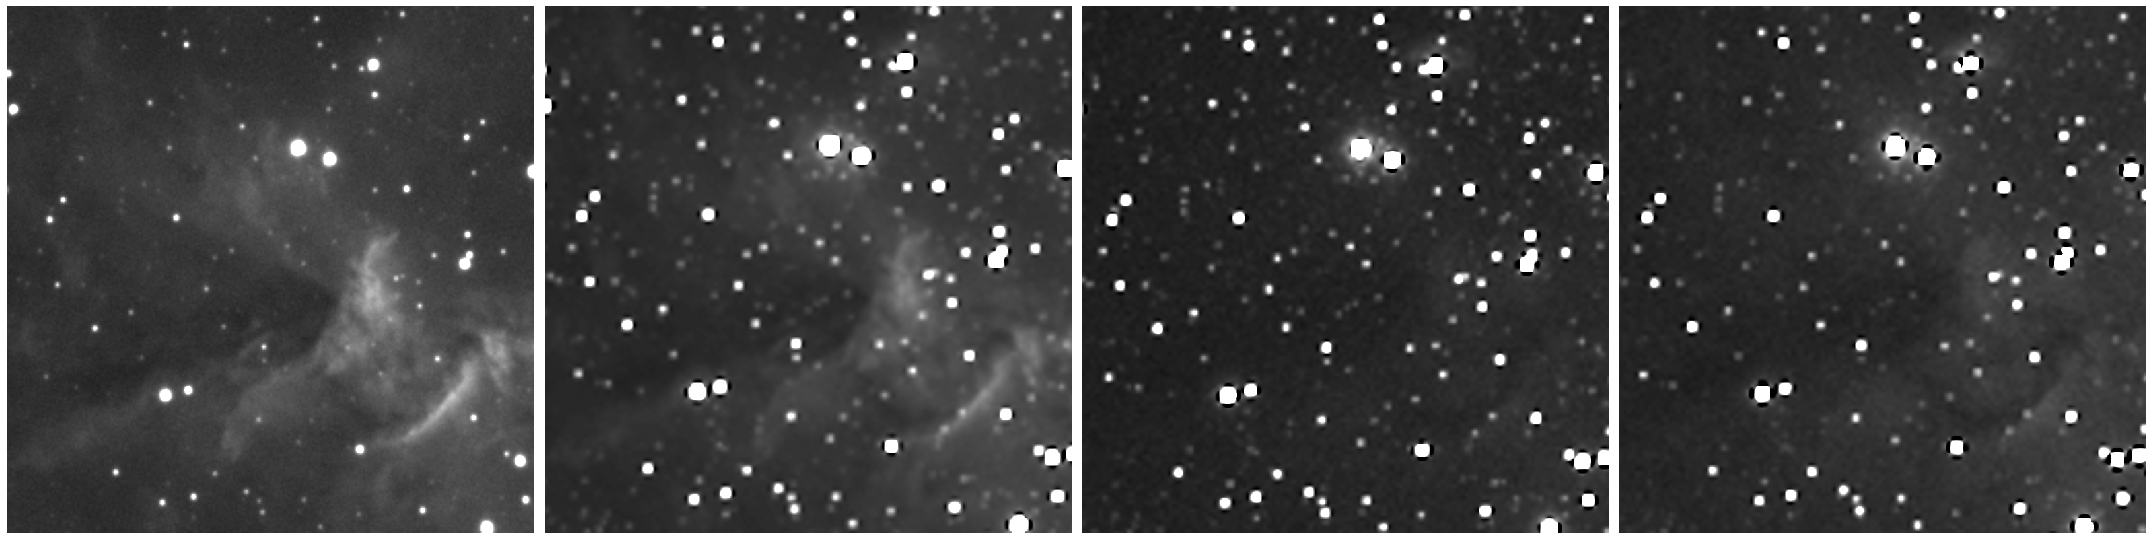

In [49]:
fov = np.s_[1500:1500+256, 2000:2000+256]
vmin = 0
vmax = np.percentile(imH, 99.7)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30, 10))
axs[0].imshow(imH[fov], vmin=vmin, vmax=1.5*vmax, cmap='gray')
axs[0].axis('off')
for i in range(3):
    axs[i+1].imshow(imRGBs[i][fov],  vmin=vmin, vmax=1.5*vmax, cmap='gray')
    axs[i+1].axis('off')
plt.tight_layout()

In [50]:
for i, image in enumerate(imRGBs):
    
    p, (pos_img, pos_img_rot) = aa.find_transform(image, imH)
    image2 = cv2.warpPerspective(image, p.params, (sz[1],sz[0]), flags=cv2.INTER_CUBIC);
    fits.writeto(Path(stack_dir, f'HRGB/{rgb[i]}_stack_coaligned.fits'), image2.astype(np.float32), overwrite=True)

In [52]:
imHRGB = [fitsread(Path(stack_dir, f'HRGB/{ch}_stack_coaligned.fits')) for ch in 'HRGB']

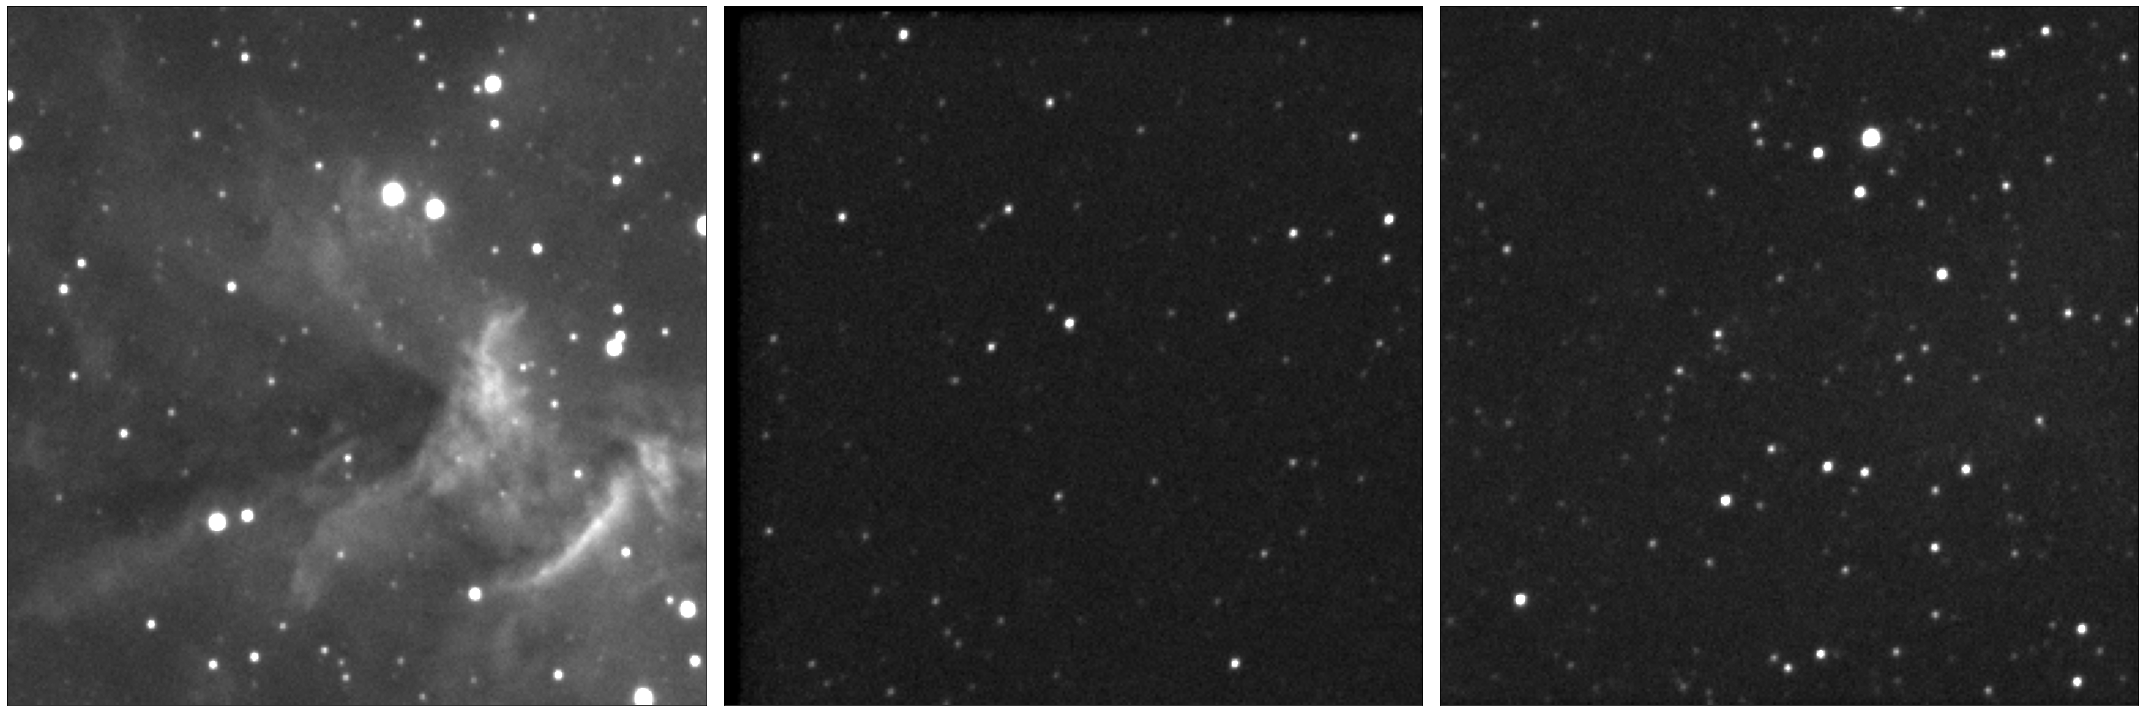

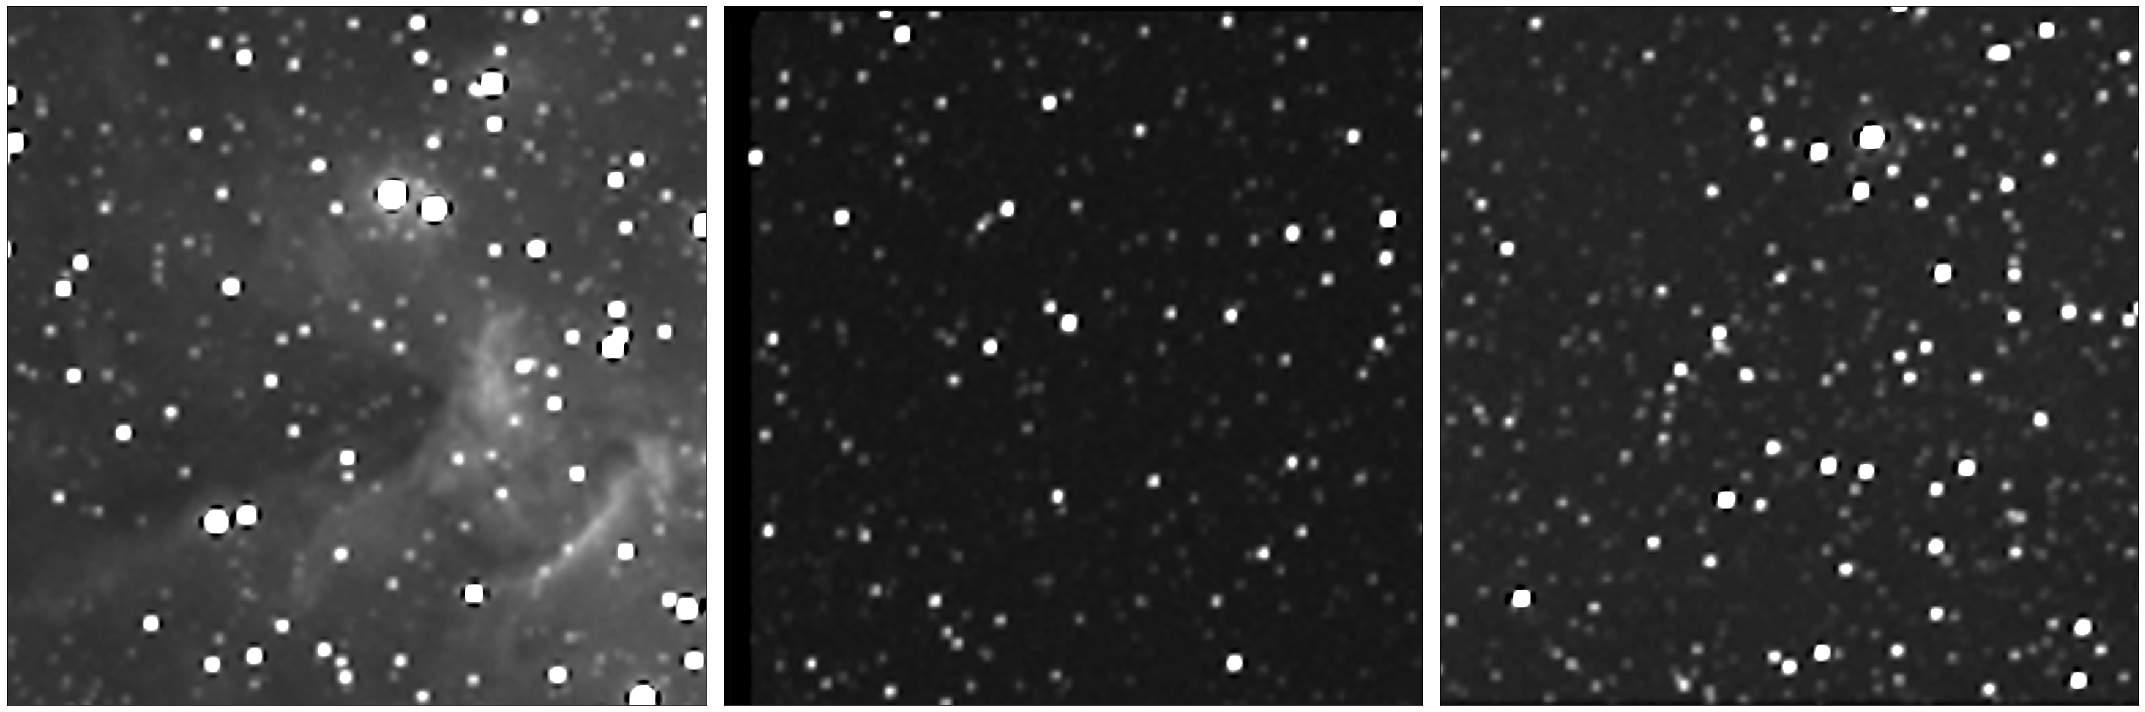

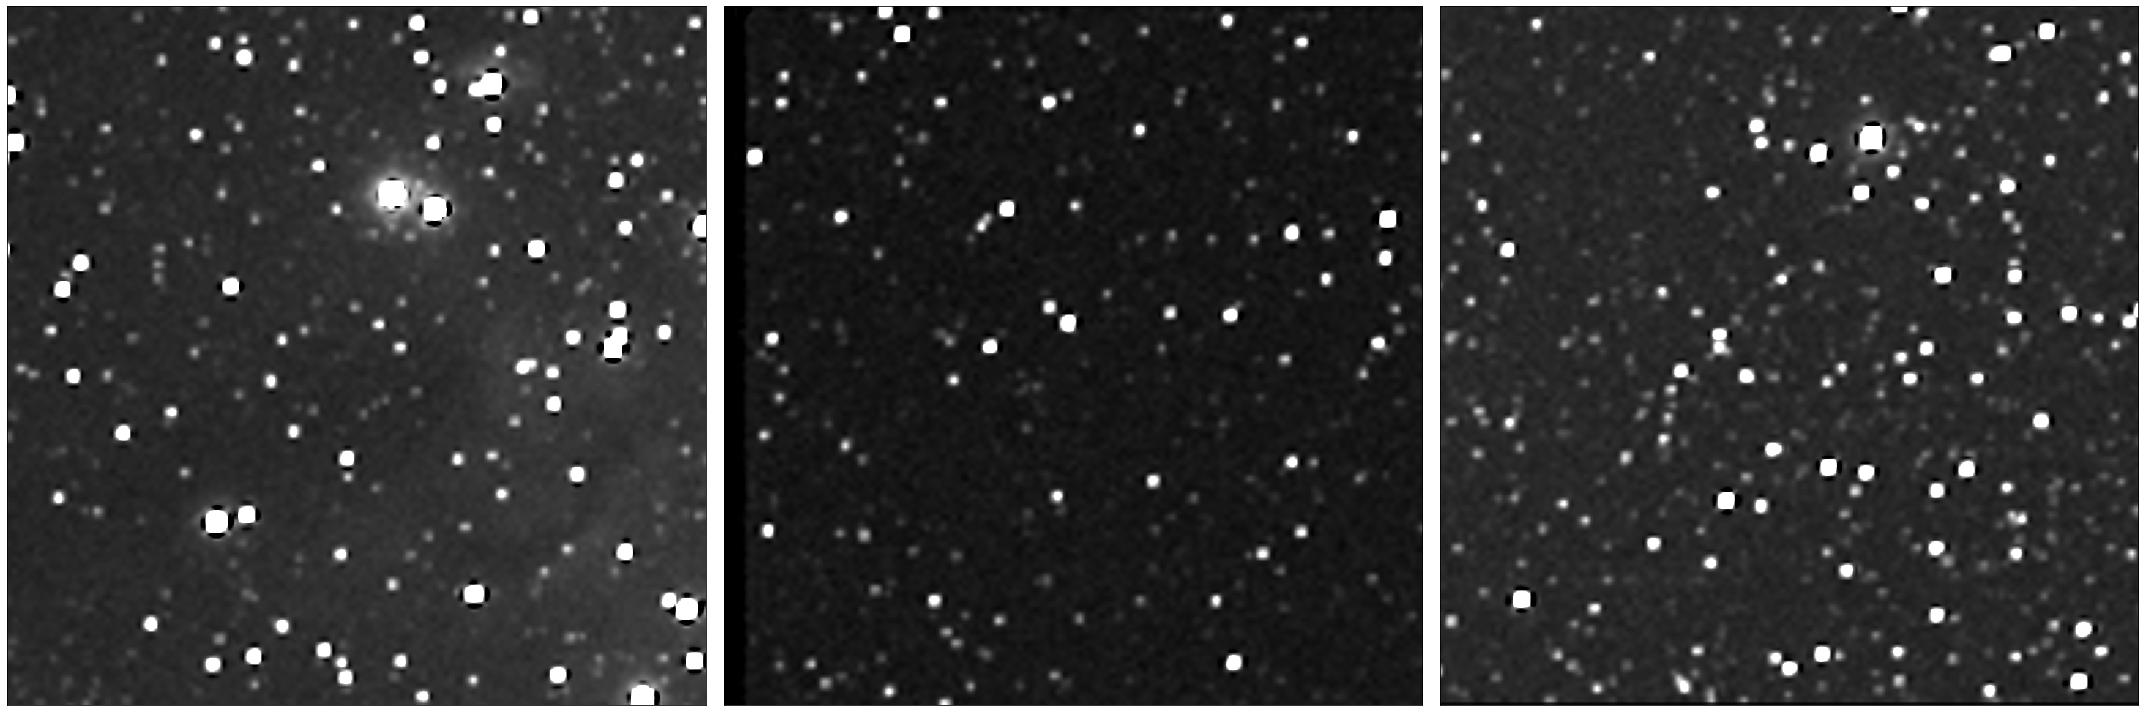

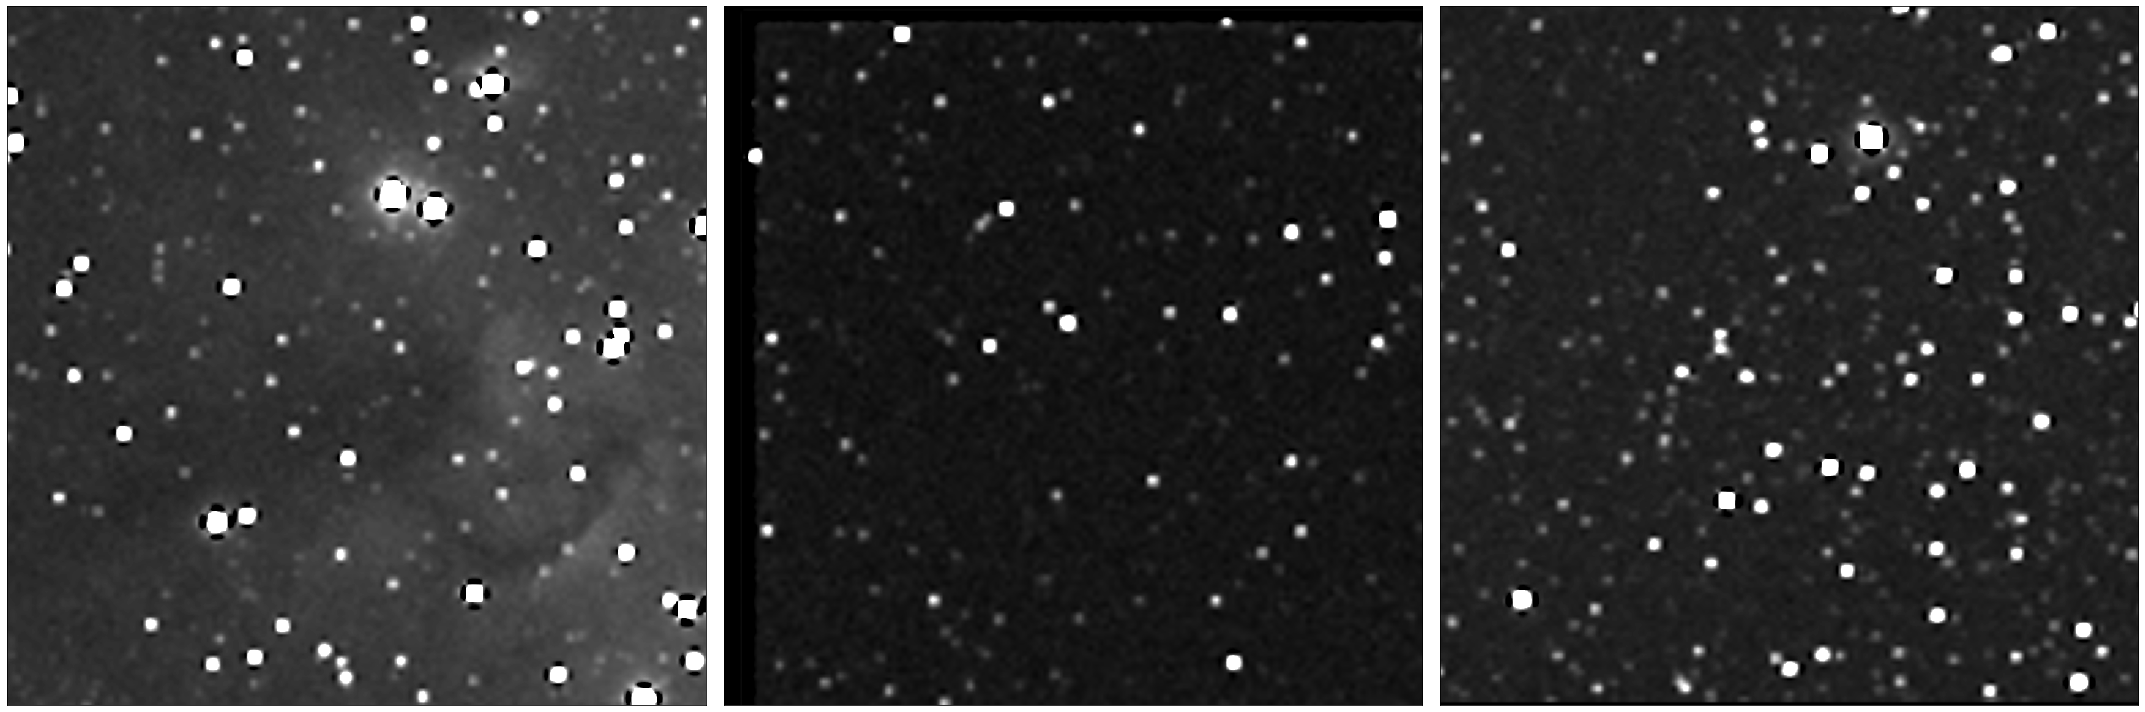

In [53]:
fov2 = np.s_[0:256, 0:256]
fov3 = np.s_[-256:, -256:]

hrgb = 'HRGB'

vmin = 0
vmax = np.percentile(imHRGB[0], 99.6)
for i, im in enumerate(imHRGB):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
    axs[0].imshow(im[fov], vmin=vmin, vmax=1.5*vmax, cmap='gray')
    axs[1].imshow(im[fov2], vmin=vmin, vmax=1.5*vmax, cmap='gray')
    axs[2].imshow(im[fov3], vmin=vmin, vmax=1.5*vmax, cmap='gray')
    axs[0].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False) 
    axs[1].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False) 
    axs[2].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False) 
    plt.tight_layout()
    plt.savefig(Path(stack_dir, f'HRGB/jpegs/{hrgb[i]}_stack_coaligned.jpg'))